# 1. Install Dependencies

In [ ]:
!pip install gym[atari]
!pip install numpy
!pip install keras==2.1.2
!pip install tensorflow==1.15.5
!pip install matplotlib

# 2. Import Dependencies

In [1]:
import numpy as np

import gym
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.optimizers import rmsprop
import keras.backend as K

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# 3. Create The Enviorment

In [2]:
env = gym.make('PongDeterministic-v4')
action_space = [4,5] # ["up","down"]

# 4. Prepare The Image

In [3]:
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 80x80x1 float """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float)[:,:,None]

# 5. Create Discounted Reward

In [4]:
gamma = 0.99
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(len(discounted_r))):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add =  r[t] + running_add * gamma # bellman's equation
        discounted_r[t] = running_add
    return discounted_r

def discount_n_standardise(r):
    # standardizes the reward by using z-scores 
    dr = discount_rewards(r)
    dr = (dr - dr.mean()) / dr.std()
    return dr

# 6. Create The Machine Learning Model

In [6]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(1,1), padding='same', activation='relu', input_shape = (80,80,1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(len(action_space), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy') #

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 80, 80, 16)        32        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 32)        544       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 64)        2112      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6400)              0         
__________

# 7. Train the Model







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Episode: 50, Average Loss: -0.0064, Average Reward: -19.8800, Average steps: 870.1600


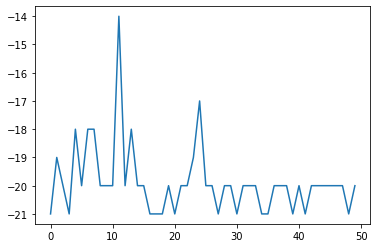

Episode: 100, Average Loss: -0.0103, Average Reward: -18.4900, Average steps: 909.1300


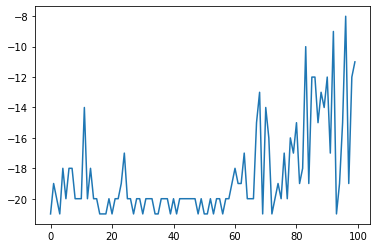

Episode: 150, Average Loss: -0.0117, Average Reward: -16.1267, Average steps: 939.4200


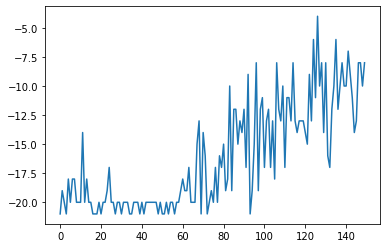

Episode: 200, Average Loss: -0.0129, Average Reward: -14.3300, Average steps: 954.5650


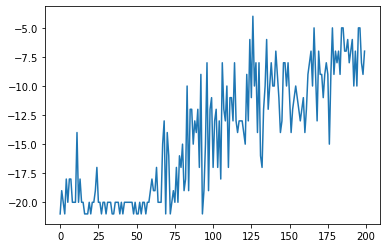

Episode: 250, Average Loss: -0.0165, Average Reward: -10.2900, Average steps: 987.0250


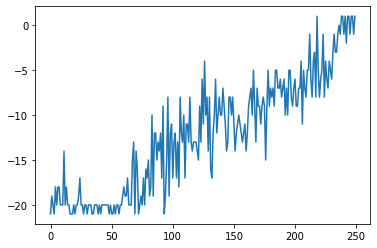

Episode: 300, Average Loss: -0.0180, Average Reward: -6.2650, Average steps: 1000.0000


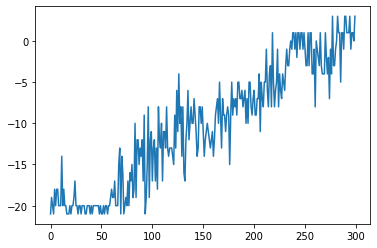

Episode: 350, Average Loss: -0.0217, Average Reward: -3.1600, Average steps: 1000.0000


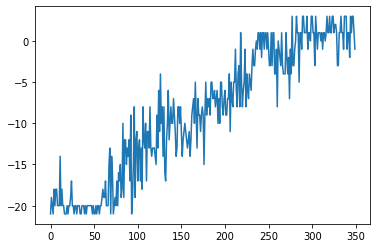

Episode: 400, Average Loss: -0.0245, Average Reward: -0.6200, Average steps: 1000.0000


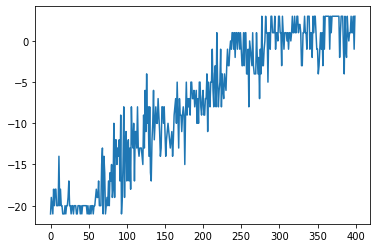

Episode: 450, Average Loss: -0.0254, Average Reward: 0.7950, Average steps: 1000.0000


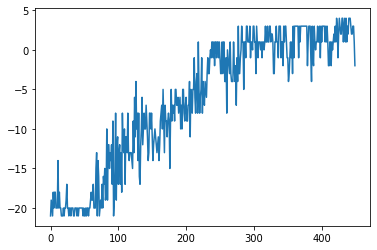

Episode: 500, Average Loss: -0.0245, Average Reward: 1.6800, Average steps: 1000.0000


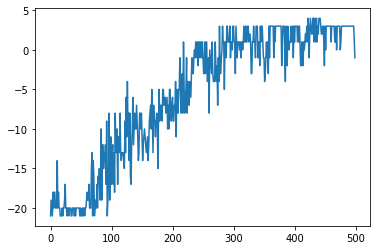

Episode: 550, Average Loss: -0.0223, Average Reward: 2.1000, Average steps: 1000.0000


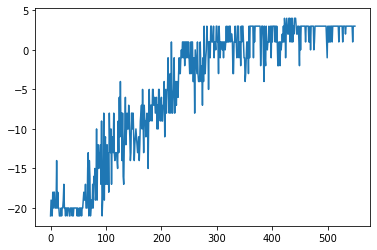

Episode: 600, Average Loss: -0.0167, Average Reward: 2.4300, Average steps: 1000.0000


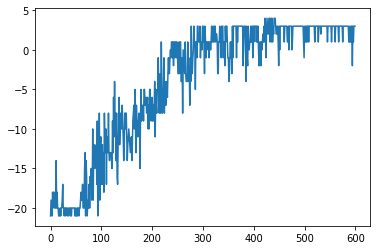

Episode: 650, Average Loss: -0.0123, Average Reward: 2.6050, Average steps: 1000.0000


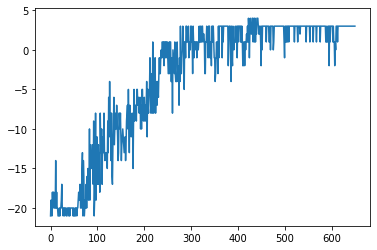

Episode: 700, Average Loss: -0.0101, Average Reward: 2.7000, Average steps: 1000.0000


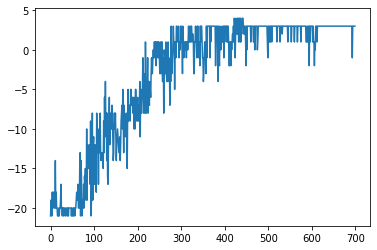

Episode: 750, Average Loss: -0.0059, Average Reward: 2.7200, Average steps: 1000.0000


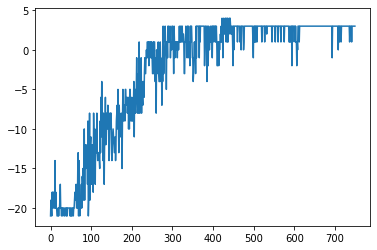

Episode: 800, Average Loss: -0.0039, Average Reward: 2.8350, Average steps: 1000.0000


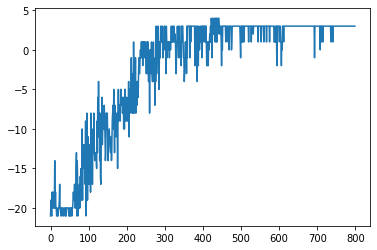

Episode: 850, Average Loss: -0.0016, Average Reward: 2.9150, Average steps: 1000.0000


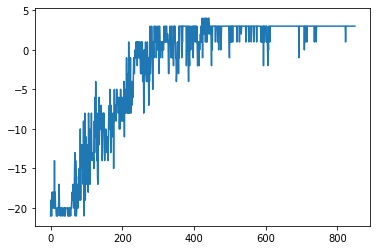

Episode: 900, Average Loss: 0.0010, Average Reward: 2.9150, Average steps: 1000.0000


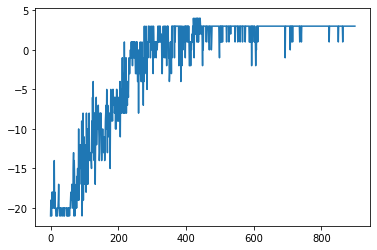

Episode: 950, Average Loss: 0.0024, Average Reward: 2.9500, Average steps: 1000.0000


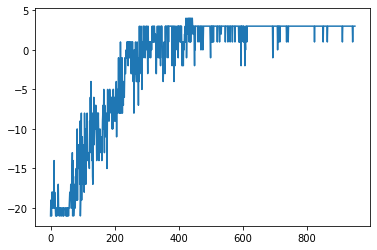

Episode: 1000, Average Loss: 0.0013, Average Reward: 2.9250, Average steps: 1000.0000


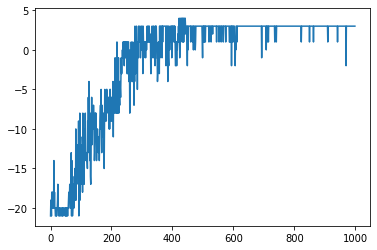

In [7]:
episodes = 0
n_episodes = 1000
reward_sums = np.zeros(n_episodes)
losses = np.zeros(n_episodes)
time_steps = np.zeros(n_episodes)
reward_sum = 0
input_shape = (80,80,1)

prev_x = None
steps = 1000
xs = np.zeros((steps,)+input_shape)
ys = np.zeros((steps,1))
rs = np.zeros((steps))

k = 0

observation = env.reset()

while episodes < n_episodes:
    env.render() # uncomment line to show the gameplay and learning
    
    # This gets the preprocessed difference of frames to be fed into the modesl
    x = prepro(observation)
    xs[k] = x - prev_x if prev_x is not None else np.zeros(input_shape)
    prev_x = x
    
    # This takes an action based on the current model, using random choice to stimuate the enviorment
    p = model.predict(xs[k][None,:,:,:])
    a = np.random.choice(len(action_space), p=p[0]) #returns either a 0 or a 1
    action = action_space[a] #sets a to an action, 0 for up, 1 for down
    ys[k] = a #saves the action
    
    # Renew state of environment
    observation, reward, done, info = env.step(action) #takes a step in the enviorment, getting a new set of varibles
    reward_sum += reward #record total rewards
    rs[k] = reward # record reward per step
    
    k += 1
    
    if done or k==steps:
        reward_sums[episodes] = reward_sum
        reward_sum = 0
        
        # Gather state, action (y), and rewards (and preprocess)
        ep_x = xs[:k]
        ep_y = ys[:k]
        ep_r = rs[:k]
        ep_r = discount_n_standardise(ep_r)
        
        model.fit(ep_x, ep_y, sample_weight=ep_r, batch_size=512, epochs=1, verbose=0)
        
        time_steps[episodes] = k
        k = 0
        prev_x = None
        observation = env.reset()
        losses[episodes] = model.evaluate(ep_x, 
                                          ep_y,
                                          sample_weight=ep_r,
                                          batch_size=len(ep_x), 
                                          verbose=0)
        
        episodes += 1
        if episodes >= 11:
            if np.mean(reward_sums[episodes-10:episodes]) >= 19:
                break

            
        # Prints out stats such as average loss, average reward, and average steps 20 times over the course of the code
        if episodes%(n_episodes//20) == 0:
            avg_reward = np.mean(reward_sums[max(0,episodes-200):episodes])
            avg_loss = np.mean(losses[max(0,episodes-200):episodes])
            avg_time = np.mean(time_steps[max(0,episodes-200):episodes])
            print('Episode: {0:d}, Average Loss: {1:.4f}, Average Reward: {2:.4f}, Average steps: {3:.4f}'
                  .format(episodes, avg_loss, avg_reward, avg_time))
            plt.plot(reward_sums[:episodes])
            plt.show()
env.close() # uncomment if env.render() is running

In [42]:
#model.save("keras_v2_adam_18_wins")
env.close()

# 8. Plot The Reward Over Episodes

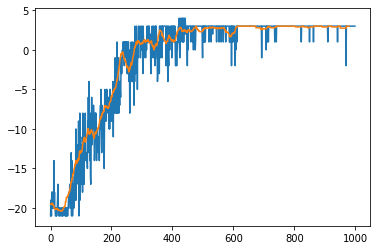

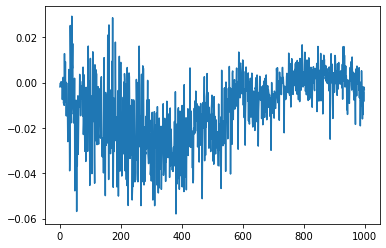

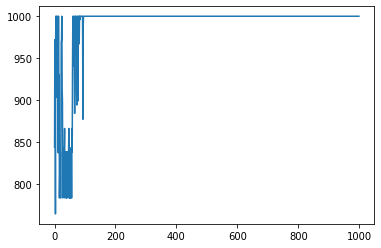

In [9]:
window = 20
plot_until = 1000
plt.plot(reward_sums[:plot_until])
plt.plot(np.convolve(reward_sums[:plot_until], np.ones((window,))/window, mode='valid'))
plt.savefig("keras_v3_adam_1k_steps.jpg")
plt.show()
plt.plot(losses[:plot_until])
plt.show()
plt.plot(time_steps[:plot_until])
plt.show()


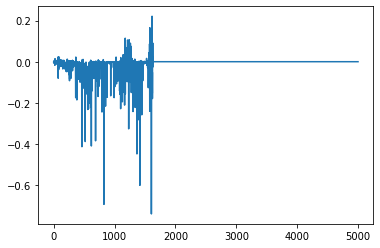

# 9. Watch The Model Play!

In [25]:
observation = env.reset()
prev_frame = None
done = False
while not done:
    x = prepro(observation) 
    diff = x - prev_frame if prev_frame is not None else np.zeros(input_shape)
    p = model.predict(diff[None,:,:,:])
    prev_frame = x
    a = np.random.choice(len(action_space), p=p[0])
    action = action_space[a]
    
    # Render into buffer. 
    env.render()
    observation, reward, done, info = env.step(action)
        
env.close()
